# Variational Autoencoder for MNIST


## What we will do:

In this exercise, we want you to implement and to train a VAE.

Dataset

Use the MNIST dataset. You can download it using tensorflow, using
tensorflow.keras.datasets.mnist.load data()

The tutorial to VAE linked in the introduction also describes how to obtain the data. Note: do not binarise
MNIST, only normalise the pixel values between 0 and 1, and split it into a training and a test set.

Model

Use a two-dimensional latent space. Use a multivariate diagonal Gaussian distribution as approximate
posterior qϕ(z|x). The encoder neural network, which outputs the mean and standard deviation of qϕ(z|x),
should consist of 2 hidden layers (dense/fully connected) with 256 units each and ReLU activation functions.
Use also a multivariate diagonal Gaussian distribution as likelihood pθ(x|z). The decoder neural network, which
outputs only the mean of pθ(x|z), should consist of 2 hidden layers (dense/fully connected) with 256 units
each and ReLU activation functions. Implement the standard deviation for the decoder distribution as
one (!) floating-point, trainable variable (make it a variable of the model, i.e. so that it does not depend on
the input x as all the other layer outputs do). Use a multivariate diagonal standard normal distribution as
prior p(z). Note: using a Bernoulli likelihood, as it is the case in most tutorials, is only possible for binarised
versions of MNIST—so you should not do it here.


In [1]:
# For automatic file reloading
%load_ext autoreload
%autoreload 2
%matplotlib inline

### We import the neccessary libraries

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from exercise_code.VAE import VAE
from exercise_code.sampling import Sampling
from exercise_code.task_3_plots import plot_losses, plot_generated, plot_all

### Set all the required parameters

In [3]:
parameters = {
    "input_shape": (28, 28, 1),
    "output_shape": 784,
    "intermediate_layers": 256,
    "latent_dim": 2,
    "adam_learning_rate": 0.001,
    "batch_size": 128,
    "epochs": 100
}

### Build the encoder

In [9]:
encoder_inputs = keras.Input(shape=parameters["input_shape"])
x = layers.Flatten()(encoder_inputs)

# First hidden layer
x = layers.Dense(parameters["intermediate_layers"], activation="relu", name="hidden_layer_1")(x)
# Second hidden layer
x = layers.Dense(parameters["intermediate_layers"], activation="relu", name="hidden_layer_2")(x)

z_mean = layers.Dense(parameters["latent_dim"], name="z_mean")(x)
z_log_var = layers.Dense(parameters["latent_dim"], name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 hidden_layer_1 (Dense)         (None, 256)          200960      ['flatten_1[0][0]']              
                                                                                                  
 hidden_layer_2 (Dense)         (None, 256)          65792       ['hidden_layer_1[0][0]']         
                                                                                            

### Build the decoder

In [10]:
latent_inputs = keras.Input(shape=(parameters["latent_dim"],))

# First hidden layer
X = layers.Dense(parameters["intermediate_layers"], activation="relu", name="hidden_layer_1")(latent_inputs)
# Second hidden layer
X = layers.Dense(parameters["intermediate_layers"], activation="relu", name="hidden_layer_2")(X)

decoder_outputs = layers.Dense(parameters["output_shape"], activation="sigmoid", name="output")(X)
decoder_outputs = layers.Reshape(parameters["input_shape"], name="reshape")(decoder_outputs)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 hidden_layer_1 (Dense)      (None, 256)               8448      
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               65792     
                                                                 
 output (Dense)              (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 275,728
Trainable params: 275,728
Non-trainable params: 0
_________________________________________________________________


### Train the VAE and display all plots

469/469 [==============================] - 4s 6ms/step - loss: 229.6756 - reconstruction_loss: 185.8538 - kl_loss: 3.6639
Plotting all losses


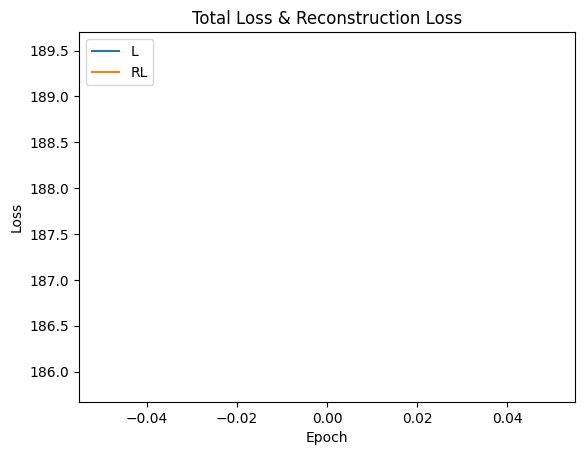

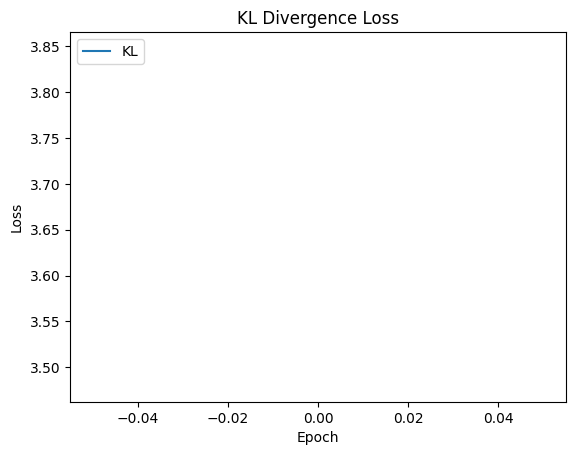

Plotting latent space


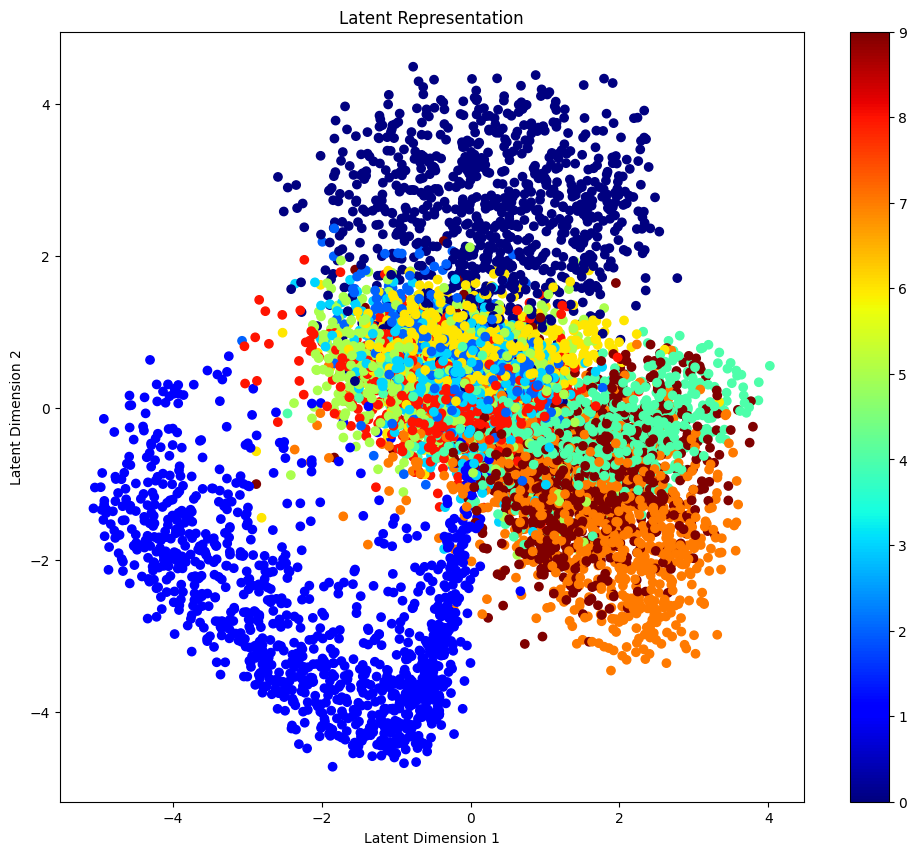

Plotting reconstructions


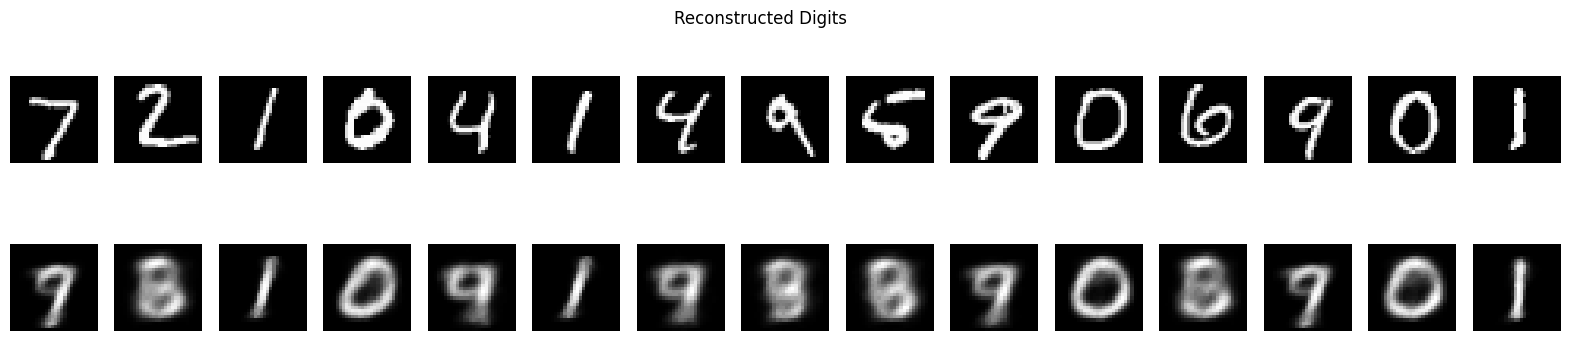

Plotting generated digits


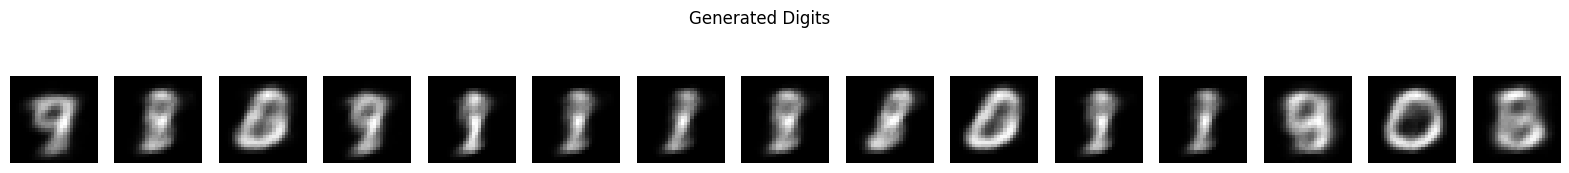

Plotting 2D manifold


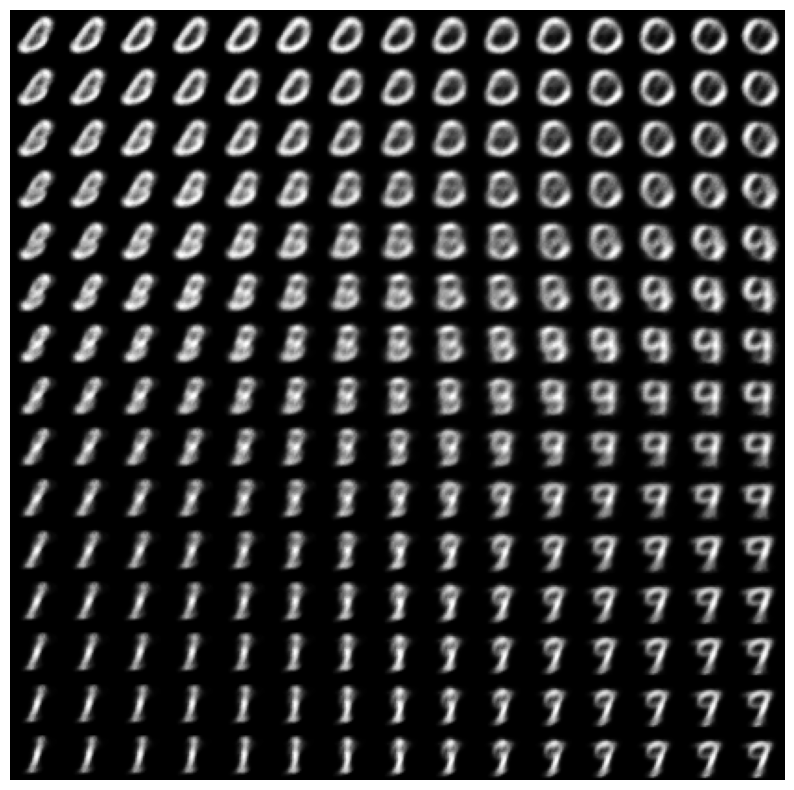

Epoch 1/4
469/469 [==============================] - 3s 6ms/step - loss: 164.2434 - reconstruction_loss: 159.8756 - kl_loss: 2.9586
Epoch 2/4
469/469 [==============================] - 3s 6ms/step - loss: 158.2167 - reconstruction_loss: 154.0069 - kl_loss: 3.1333
Epoch 3/4
469/469 [==============================] - 3s 6ms/step - loss: 153.6201 - reconstruction_loss: 149.7284 - kl_loss: 3.2954
Epoch 4/4
 91/469 [====>.........................] - ETA: 2s - loss: 151.0721 - reconstruction_loss: 147.8157 - kl_loss: 3.3577

KeyboardInterrupt: 

In [6]:
# Perform the experiments

# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255


# Create an instance of the VAE class
vae = VAE(encoder, decoder, scale=28*28)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=parameters["adam_learning_rate"])
vae.compile(optimizer)

loss_history = {
    'loss': [],
    'reconstruction_loss': [],
    'kl_loss': []
}

# Train the model for each stage and accumulate the losses
for stage, num_epochs in enumerate([1, 4, 20, 25]):
    # Train the model for the specified number of epochs
    h = vae.fit(x_train, epochs=num_epochs, batch_size=parameters["batch_size"])
    
    # Concatenate the dictionaries
    for key in loss_history.keys():
        loss_history[key] = loss_history[key] + h.history[key]

    # Plot all displays
    plot_all(vae, x_test, y_test, loss_history)

In [7]:
# Plot after convergence (Continued training until 100 epochs were reached)
h = vae.fit(x_train, epochs=50, batch_size=128)

for key in loss_history.keys():
        loss_history[key] = loss_history[key] + h.history[key]

plot_all(vae, x_test, y_test, loss_history)

Epoch 1/50
469/469 [==============================] - 3s 6ms/step - loss: 150.3800 - reconstruction_loss: 146.5345 - kl_loss: 3.3999
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 148.3768 - reconstruction_loss: 144.4187 - kl_loss: 3.4620
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 146.4743 - reconstruction_loss: 142.8783 - kl_loss: 3.5072
Epoch 4/50
458/469 [============================>.] - ETA: 0s - loss: 145.2646 - reconstruction_loss: 141.4710 - kl_loss: 3.5418

KeyboardInterrupt: 

### Change the latent space dimension to 32

In [8]:
# Change latent_dim in the parameters variable
parameters["latent_dim"] = 32
parameters

{'input_shape': (28, 28, 1),
 'output_shape': 784,
 'intermediate_layers': 256,
 'latent_dim': 32,
 'adam_learning_rate': 0.001,
 'batch_size': 128,
 'epochs': 100}

### Train the VAE in the new latent dimension

In [11]:
# Perform the experiment
### IMPORTANT: The ENCODER and DECODER set up cells need to be ran again to restart the training and change their latent sizes

# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255


# Create an instance of the VAE class
vae = VAE(encoder, decoder)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=parameters["adam_learning_rate"])
vae.compile(optimizer)

# Plot after the 100th epoch
h = vae.fit(x_train, epochs=parameters["epochs"], batch_size=parameters["batch_size"])

print("Plotting losses")
plot_losses(h.history)

print("Plotting generated digits")
plot_generated(vae)


Epoch 1/100
469/469 [==============================] - 4s 6ms/step - loss: 190.6582 - reconstruction_loss: 131.3784 - kl_loss: 2.8169
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 87.1308 - reconstruction_loss: 80.6547 - kl_loss: 3.3563
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 77.3301 - reconstruction_loss: 72.8786 - kl_loss: 3.2572
Epoch 4/100
306/469 [==================>...........] - ETA: 1s - loss: 73.1771 - reconstruction_loss: 69.6046 - kl_loss: 3.1959

KeyboardInterrupt: 